In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
TRAIN_IMG_DIR = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\train-image\\image"
TEST_IMG_DIR = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\test-images"
ANNOTATIONS_FILE = "D:\\ISIC 2024 - Skin Cancer Detection with 3D-TBP\\Data\\train-metadata.csv"

# Image transformations and augmentations
TRAIN_TRANS = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.RandomRotation(degrees=(0, 360)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale = True)
])
TEST_TRANS = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True)
])

In [38]:
class ISIC2024_JPG(Dataset):
    '''
    
    '''
    def __init__(self, image_dir, annotations_file = None, transform=None):
        self.root_dir = image_dir
        self.annotations_file = annotations_file
        self.transform = transform
        self.image_paths = []       # initializing empty array for storing all image paths
        self.labels = None          # to keep labels if annotation file is given
        image_files = os.listdir(image_dir)     # listing all image names in the directory
        self.image_paths.extend([os.path.join(image_dir, image_file) for image_file in image_files])    # adding all image paths in the list
        if self.annotations_file is not None:
            '''
            Setting the 'isic_id' column as the index allows pandas to use a highly optimized internal structure (hash table) for fast lookups. 
            This operation is O(n), but it is performed only once.
            This is to search for the image name in the csv file efficiently
            '''
            image_names = [name.split('.')[0] for name in image_files]
            df = pd.read_csv(annotations_file, low_memory=False)
            df.set_index('isic_id', inplace=True)
            self.labels = df.loc[image_names, 'target'].values

    def __len__(self):
        return(len(self.image_paths))

    def __getitem__(self, idx):
        if self.annotations_file is not None:       # case for working with training images, which has labels
            img_path = self.image_paths[idx]        # take image paths one-by-one
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            image_name = os.path.basename(img_path).split('.')[0]  # retrieve image name from the full path
            label = self.labels[idx]

            return image, image_name, label
        else:                                       # case for working with test images, which does not have labels
            img_path = self.image_paths[idx]
            image_name = os.path.basename(img_path).split('.')[0]  # retrieve image name from the full path
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            return image, image_name

In [28]:
def get_loader(dataset = ISIC2024_JPG,
                train_data_dir = TRAIN_IMG_DIR, 
                train_labels_file = ANNOTATIONS_FILE, 
                test_data_dir = TEST_IMG_DIR, 
                train_img_trans = TRAIN_TRANS, 
                test_img_trans = TEST_TRANS, 
                batch = 32, 
                seed = None):
    '''
    
    '''
    isic2024_train_dataset_all = dataset(image_dir=train_data_dir, annotations_file=train_labels_file, transform=train_img_trans)
    isic2024_test_dataset = dataset(image_dir=test_data_dir, transform=test_img_trans)
    train_annotations_all = pd.read_csv(train_labels_file, low_memory=False)
    labels = train_annotations_all['target']
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_idx, val_idx = next(splitter.split(train_annotations_all, labels))
    train_subset = Subset(isic2024_train_dataset_all, train_idx)
    val_subset = Subset(isic2024_train_dataset_all, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch, shuffle=True)
    test_loader = DataLoader(isic2024_test_dataset, shuffle=False)

    return train_loader, val_loader, test_loader

In [39]:
train_dl, val_dl, test_dl = get_loader(batch=16, seed = 42)

In [7]:
# def vis(loader, num_images):
#     count = 0
#     for image, image_name, label in loader:
#         plt.imshow(image[0].permute(1, 2, 0))
#         plt.title(f"Image: {image_name[0]}, label: {label[0].item()}")
#         plt.axis('off')
#         plt.show()
#         exit()
#         count += 1
#         if count >= num_images:
#             return

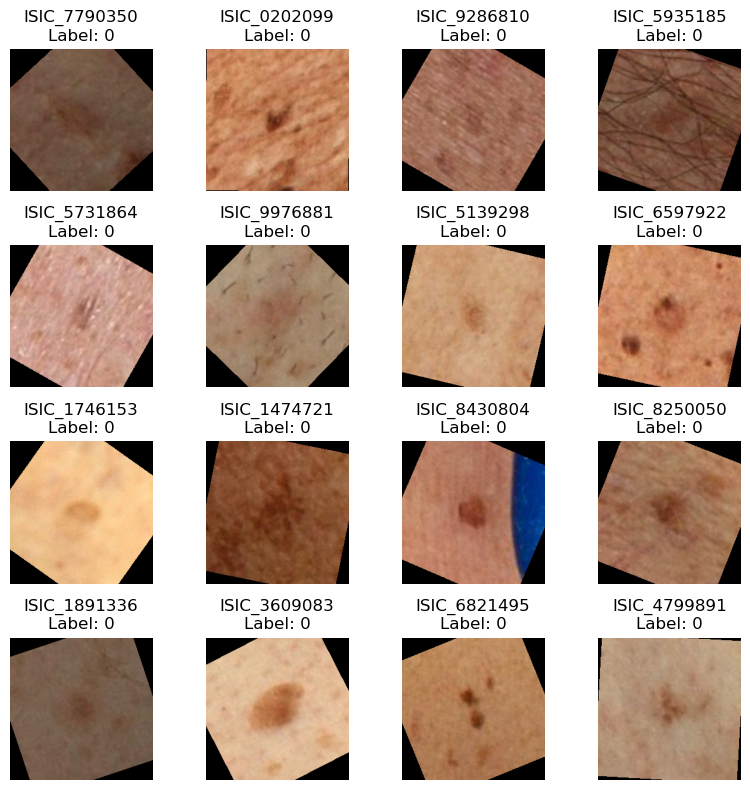

In [26]:
for batch_idx, (images, image_names, labels) in enumerate(train_dl):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Convert image tensor to numpy array and transpose (channels, height, width) to (height, width, channels)
            image_np = np.transpose(images[i].numpy(), (1, 2, 0))
            ax.imshow(image_np)
            ax.set_title(f'{image_names[i]}\nLabel: {labels[i].item()}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if batch_idx >= 0:  # Set a limit for demonstration (remove or adjust as needed)
        break

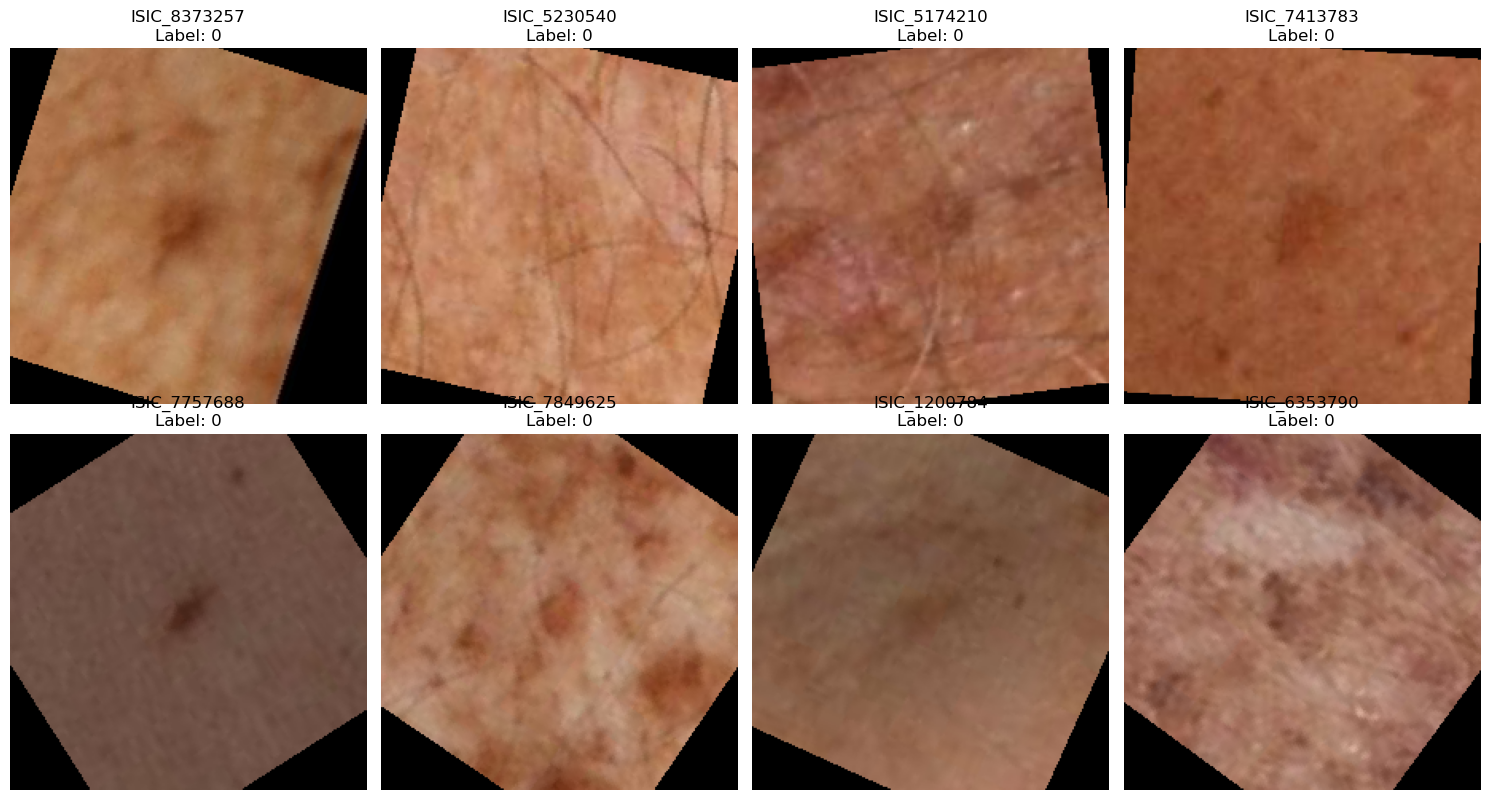

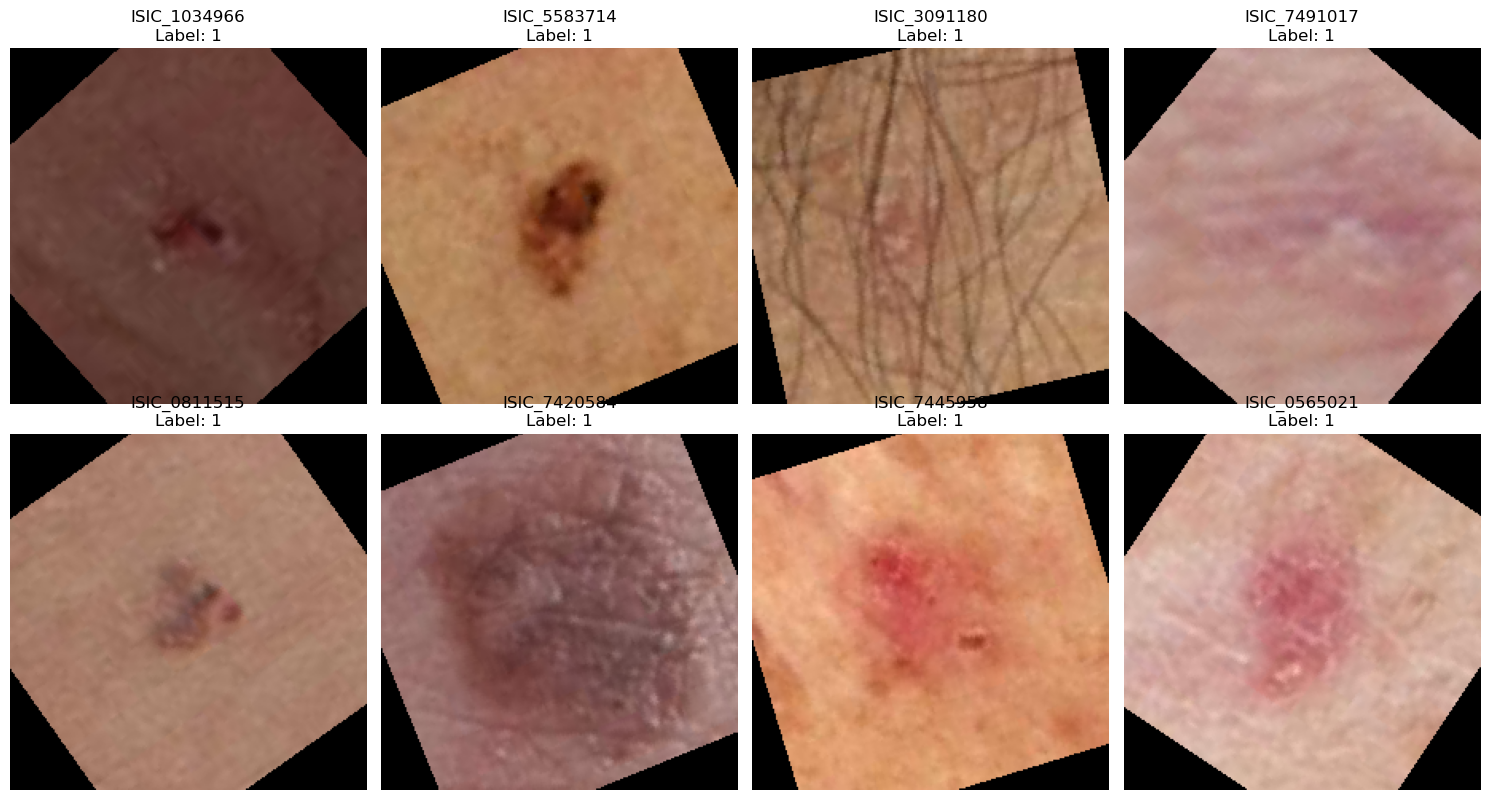

In [27]:
count_0 = 0
count_1 = 0
images_0 = []
images_1 = []
image_names_0 = []
image_names_1 = []

# Iterate through DataLoader
for images, image_names, labels in train_dl:
    for i in range(len(images)):
        if labels[i].item() == 0 and count_0 < 8:
            images_0.append(images[i])
            image_names_0.append(image_names[i])
            count_0 += 1
        elif labels[i].item() == 1 and count_1 < 8:
            images_1.append(images[i])
            image_names_1.append(image_names[i])
            count_1 += 1
        
        if count_0 >= 8 and count_1 >= 8:
            break
    if count_0 >= 8 and count_1 >= 8:
        break

# Plotting images with label 0
fig, axes = plt.subplots(2, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image_np = np.transpose(images_0[i].numpy(), (1, 2, 0))
    ax.imshow(image_np)
    ax.set_title(f'{image_names_0[i]}\nLabel: 0')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Plotting images with label 1
fig, axes = plt.subplots(2, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image_np = np.transpose(images_1[i].numpy(), (1, 2, 0))
    ax.imshow(image_np)
    ax.set_title(f'{image_names_1[i]}\nLabel: 1')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [31]:
for image, image_name in test_dl:
    print(type(image), type(image_name))
    print(image.shape)
    print(image_name)
    break

<class 'torch.Tensor'> <class 'tuple'>
torch.Size([1, 3, 224, 224])
('ISIC_0015657',)


In [42]:
def vis(loader, num_images):
    count = 0
    for image, image_name in loader:
        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"Image: {image_name[0]}")
        plt.axis('off')
        plt.show()
        # exit()
        count += 1
        if count >= num_images:
            return

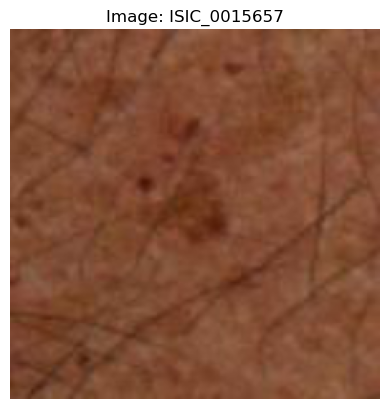

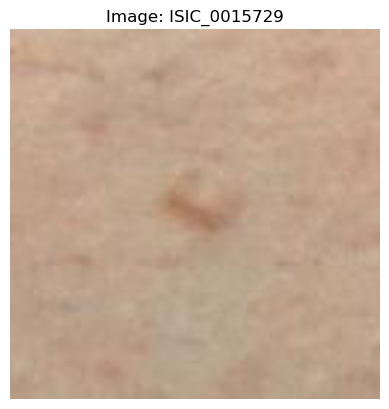

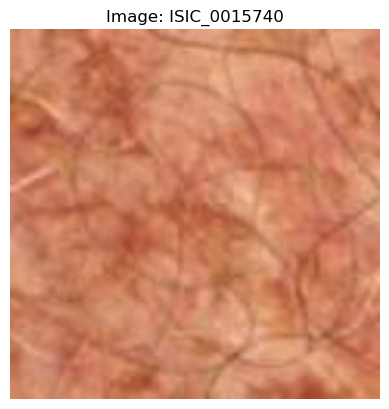

In [43]:
vis(test_dl, 3)